# Оглавление <a name='toc'>
    
<ol>
<li><a href='#intro'>Введение</a></li>
<li><a href='#libs'>Загрузка библиотек</a></li>
<li><a href='#funcs'>Описание функций</a></li>
<li><a href='#model'>Создание модели</a></li>
<li><a href='#training'>Пробная тренировка модели</a></li>
<li><a href='#synth_prediction'>Предсказание аномалий в синтетических данных</a></li>
<li><a href='#real_prediction'>Предсказание аномалий в реальных данных</a></li>
<li><a href='#links'>Ссылки</a></li>
</ol>


# Введение <a name='intro'></a>

Timeseries anomaly detection with Generative Adversarial Network (TadGAN) это метод поиска аномалий во временных рядах. Основная идея метода изложена авторами в статье "TadGAN: Time Series Anomaly Detection Using Generative Adversarial Networks" https://arxiv.org/abs/2009.07769 и в ролике https://www.youtube.com/watch?v=jIDj2dhU99k

<a href='#toc'>Назад к Оглавлению</a>

# Загрузка библиотек

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

<a href='#toc'>Назад к Оглавлению</a>

# Описание функций <a name='funcs'></a>

In [2]:
def get_reconstruction_segment(model, values, start, end):
    """
    Автокодировщик model получает на вход сигнал values и 
    возвращает реконструированные (декодированные) значения 
    для заданного сегмента [start, end].
    Поскольку автокодировщик требует постоянное число сэмплов на входе, то для
    последнего набора данных берется сегмент [end-WINWOW_SIZE, end].
    """
    num = int((end - start)/WINDOW_SIZE)
    data = []
    left, right = 0, WINDOW_SIZE
    
    for i in range(num):
        result = model.predict(np.array(values[left:right]).reshape(1,-1))
        data = np.r_[data, result[0]]
        left += WINDOW_SIZE
        right += WINDOW_SIZE           
       
    if left < end:
        result = model.predict(np.array(values[end-WINDOW_SIZE:end]).reshape(1,-1)).reshape(-1,1)
        data = np.r_[data, result[-end+left:].squeeze()]
    
    return np.array(data) 
    

In [3]:
def draw_reconstruction_segment(xs, ys, ys_hat, start, end, c='g'):
    """
    Рисует истинные и предсказанные значения для заданного сегмента
    """
    plt.figure(figsize=(20,5))        
    plt.plot(xs[start:end], ys[start:end], c='b', alpha=0.7, label="Исходный сигнал")
    plt.scatter(xs[start:end], ys_hat[start:end], c=c, label="Восстановленный сигнал")
    
    plt.legend()
    plt.show()
    

In [4]:
def draw_anomalies(xs, ys, ys_hat, start, end, labels, labels_hat):
    """
    Рисует аномалии
    """
    plt.figure(figsize=(20, 10))
    plt.plot(xs[start:end], ys[start:end], c='b', alpha=0.7, label="Исходный сигнал")
    plt.scatter(xs[start:end], ys_hat[start:end], c=c, label="Восстановленный сигнал")
    
    l_, r_ = start, end
    plt.plot(xs[l_:r_], ys[l_:r_])
    plt.plot(xs[l_:r_], ys_hat[l_:r_], c='g', label="предсказанные значения")
    plt.scatter(xs[l_:r_], labels[l_:r_]-5, c='r', label="размеченные аномалии")
    plt.scatter(xs[l_:r_], labels_hat[l_:r_]-3, c='b', label="найденные аномалии")
    plt.title("f1: {}".format(f1_score(labels, labels_hat)))
    
    plt.legend()
    plt.show()
    

In [5]:
def draw_losses(aeLoss, cxLoss, czLoss, cx_g_Loss, cz_g_Loss):
    """
    Рисует графики массивов, которые в программе используются для хранения ошибок
    """    
    plt.figure(figsize=(20,10))
    plt.plot(aeLoss, label="aeLoss")
    plt.plot(cxLoss, label="cxLoss")
    plt.plot(czLoss, label="czLoss")
    plt.plot(cx_g_Loss, label="cx_g_Loss")
    plt.plot(cz_g_Loss, label="cz_g_Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

#### Функции для вычисления расхождений между двумя рядами, если расстояние превышает заданный порог, то принимается решение о наличии аномалии

In [6]:
def check_anomaly_pointwise_abs(ys, ys_hat, threeshold):
    """
    Поточечное сравнение, модуль расстояния
    """
    result = []
    for y1, y2 in zip(ys, ys_hat):
        if np.abs(y1-y2) > threeshold:
            result.append(1)
        else:
            result.append(0)
            
    return np.array(result)

In [129]:
def check_anomaly_groupwise_MSE(ys, ys_hat, threeshold):
    """
    Среднеквадратичное отклонение для группы точек
    """
    if np.sum(np.power(ys-ys_hat,2))/len(ys) > threeshold:
        return 1
    else:
        return 0


In [8]:
def check_anomaly_groupswise_area(y, yhat, threeshold):
    """
    Разность площадей под двумя кривыми, вычисление по формуле трапеций
    """
    result = []
    S1, S2 = 0, 0
    for l, r in zip(y, y[1:]):
        S1 += (l+r)/2
    for l, r in zip(yhat, yhat[1:]):
        S2 += (l+r)/2
        
    if np.abs(S1-S2) > threeshold:
        return 1
    else:
        return 0
    

In [9]:
def check_anomaly_groupswise_DTW(y, yhat, threeshold):
    
    pass
    

<a href='#toc'>Назад к Оглавлению</a>

# Создание модели <a name='model'></a>

Модель описана подробно авторами в статье, архитектура модуля (схема из видео https://www.youtube.com/watch?v=jIDj2dhU99k&t=623s).

<img src="./tad-gan.jpg">

На вход кодировщику $E$ подяется отрезок временного ряда $x$, который преобразуется в латентный (скрытый) вектор $z$ размерности, меньшей чем размерность $x$ (кодирование сигнала в автокодировщике). Декодер $G$ восстанавливает сигнал из латентного вектора. При этом декодер $G$ также выступает в роли генератора сигнала работу которого проверяет критик (дискриминатор) $C_x$ (в соответствии с принципами работы сетей GAN). Также присутствует дополнительный критик $C_z$, который оценивает качетсво работы кодировщика $E$, а именно - похожесть закодированного скрытого сигнала на случайный сигнал.

In [10]:
LATENT_VECTOR_SIZE = 10
WINDOW_SIZE = 100

In [19]:
def init_model():

    adam = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    
    E = Sequential()
    E.add(L.InputLayer(WINDOW_SIZE))
    E.add(L.Dense(WINDOW_SIZE*2, activation='relu'))
    E.add(L.Dropout(0.3))        
    E.add(L.Dense(WINDOW_SIZE, activation='relu'))
    E.add(L.Dropout(0.3))        
    E.add(L.Dense(LATENT_VECTOR_SIZE))
    
    G = Sequential()
    G.add(L.Dense(128, input_dim=LATENT_VECTOR_SIZE))
    G.add(L.LeakyReLU(0.2))
    G.add(L.Dropout(0.3))        
    G.add(L.Dense(256))
    G.add(L.LeakyReLU(0.2))
    G.add(L.Dropout(0.3))        
    G.add(L.Dense(512))
    G.add(L.LeakyReLU(0.2))
    G.add(L.Dropout(0.3))        
    G.add(L.Dense(WINDOW_SIZE, activation='tanh'))
    G.compile(loss='binary_crossentropy', optimizer=adam)
    
    Cx = Sequential()
    Cx.add(L.Dense(1024, input_dim=WINDOW_SIZE))
    Cx.add(L.LeakyReLU(0.2))
    Cx.add(L.Dropout(0.3))
    Cx.add(L.Dense(512, input_dim=WINDOW_SIZE))
    Cx.add(L.LeakyReLU(0.2))
    Cx.add(L.Dropout(0.3))
    Cx.add(L.Dense(256))
    Cx.add(L.LeakyReLU(0.2))
    Cx.add(L.Dropout(0.3))
    Cx.add(L.Dense(1, activation='sigmoid'))
    Cx.compile(loss='binary_crossentropy', optimizer=adam)
    
    Cz = Sequential()
    Cz.add(L.Dense(1024, input_dim=LATENT_VECTOR_SIZE))
    Cz.add(L.LeakyReLU(0.2))
    Cz.add(L.Dropout(0.3))
    Cz.add(L.Dense(512))
    Cz.add(L.LeakyReLU(0.2))
    Cz.add(L.Dropout(0.3))
    Cz.add(L.Dense(256))
    Cz.add(L.LeakyReLU(0.2))
    Cz.add(L.Dropout(0.3))
    Cz.add(L.Dense(1, activation='sigmoid'))
    Cz.compile(loss='binary_crossentropy', optimizer=adam)
    
    ae_input = L.Input(WINDOW_SIZE)
    ae_code = E(ae_input)
    ae_reconstruction = G(ae_code)
    ae_model = Model(inputs=ae_input, outputs=ae_reconstruction)
    ae_model.compile(loss='mse', optimizer=adam)
    
    cx_gan_input = L.Input(LATENT_VECTOR_SIZE)
    cx_gan_code = G(cx_gan_input)
    cx_gan_output = Cx(cx_gan_code)
    cx_gan_model = Model(inputs=cx_gan_input, outputs=cx_gan_output)
    cx_gan_model.compile(loss='binary_crossentropy', optimizer=adam)
    
    cz_gan_input = L.Input(WINDOW_SIZE)
    cz_gan_code = E(cz_gan_input)
    cz_gan_output = Cz(cz_gan_code)
    cz_gan_model = Model(inputs=cz_gan_input, outputs=cz_gan_output)
    cz_gan_model.compile(loss='binary_crossentropy', optimizer=adam)
    
    return E, G, Cx, Cz, ae_model, cx_gan_model, cz_gan_model
        

In [20]:
def train_model(X_train, epochs=1, batch_size=128):
 
    batchCount = int(X_train.shape[0] / batch_size)

    for epoch in range(1, epochs+1):
        print("-"*10, "Epoch: {}, batchCount {}".format(epoch, batchCount), "-"*10)

        for _ in range(batchCount):
            
            # обучение дискриминатора Cx
            Cx.trainable = True            
            idxs = np.random.choice(len(X_train)-WINDOW_SIZE, size=batch_size, replace=False)
            fake = G.predict(np.random.normal(0, 1, size=(batch_size, LATENT_VECTOR_SIZE)))
            X = []
            for i in idxs:
                X.append(X_train[i:i+WINDOW_SIZE])
            X = np.r_[X, fake]
            labels = np.r_[np.ones(shape=batch_size)*0.95, np.zeros(shape=batch_size)]
            cx_loss = Cx.train_on_batch(X, labels)

            # обучение генератора cx_gan_model обманывать дискриминатор Cx
            Cx.trainable = False
            labels = np.ones(shape=batch_size)            
            X = np.random.normal(0, 1, size=(batch_size, LATENT_VECTOR_SIZE))
            cx_g_loss = cx_gan_model.train_on_batch(X, labels)            
            
            # обучение дискриминатора Cz
            Cz.trainable = True            
            idxs = np.random.choice(len(X_train)-WINDOW_SIZE, size=batch_size, replace=False)
            fake = np.array([X_train[i:i+WINDOW_SIZE] for i in idxs])
            fake = E.predict(fake)
            X = np.random.normal(0, 1, size=(batch_size, LATENT_VECTOR_SIZE))
            X = np.r_[X, fake]
            labels = np.r_[np.ones(shape=batch_size)*0.95, np.zeros(shape=batch_size)]
            cz_loss = Cz.train_on_batch(X, labels)

            # обучение генератора cx_gan_model обманывать дискриминатор Cz
            Cz.trainable = False
            idxs = np.random.choice(len(X_train)-WINDOW_SIZE, size=batch_size, replace=False)
            X = []
            for i in idxs:
                X.append(X_train[i:i+WINDOW_SIZE])            
            X = np.array(X)
            labels = np.ones(shape=batch_size)                        
            cz_g_loss = cz_gan_model.train_on_batch(X, labels)

            
            # обучение автокодировщика AE
            idxs = np.random.choice(len(X_train)-WINDOW_SIZE, size=batch_size, replace=False)
            X = []
            for i in idxs:
                X.append(X_train[i:i+WINDOW_SIZE])
            E.trainable = True
            G.trainable = True
            X = np.array(X)
            ae_loss = ae_model.train_on_batch(X, X)
            

        # оценка ошибок и периодическое сохранение картинок
        aeLoss.append(ae_loss)
        cxLoss.append(cx_loss)
        czLoss.append(cz_loss)
        cx_g_Loss.append(cx_g_loss)
        cz_g_Loss.append(cz_g_loss)

        if epoch % 4 == 0:                        
            print("Эпоха {}".format(epoch))
            print("ae_loss {}, cx_loss {}, cz_loss {}, cx_g_loss {}, cz_g_loss {}".format(ae_loss, 
                                                                                          cx_loss, 
                                                                                          cz_loss, 
                                                                                          cx_g_loss,
                                                                                          cz_g_loss))
            ae_model.save_weights("./ae_model-weights-epoch-{}.h5".format(epoch))


<a href='#toc'>Назад к Оглавлению</a>

# Пробная тренировка модели <a name='training'></a>

Для опробования модели обучим построенную сеть TadGAN на синтетических данных без аномалий.

In [21]:
xs = np.linspace(0, 1000, 10000)
ys1 = 0.5*np.sin(xs) + 0.5*np.sin(0.8*xs)
label1 = np.zeros(10000)

In [22]:
df = pd.DataFrame({'values': ys1, 'labels': label1})
df.head(5)

,values,labels
0,0.000000,0.0
1,0.089883,0.0
2,0.179011,0.0
3,0.266637,0.0
4,0.352026,0.0


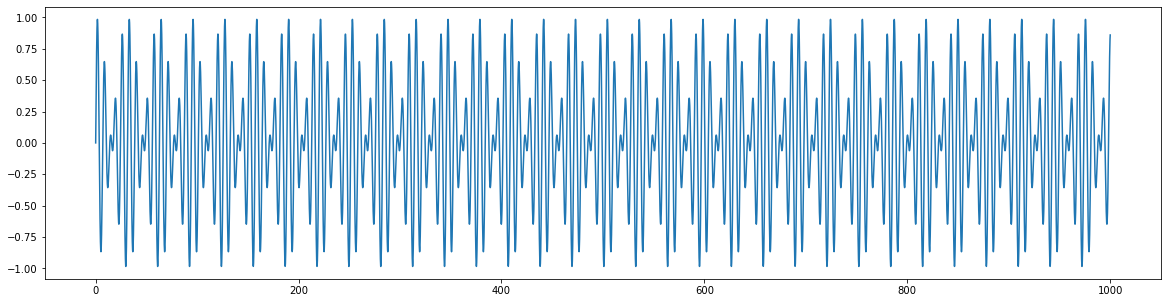

In [23]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys1)
plt.show()

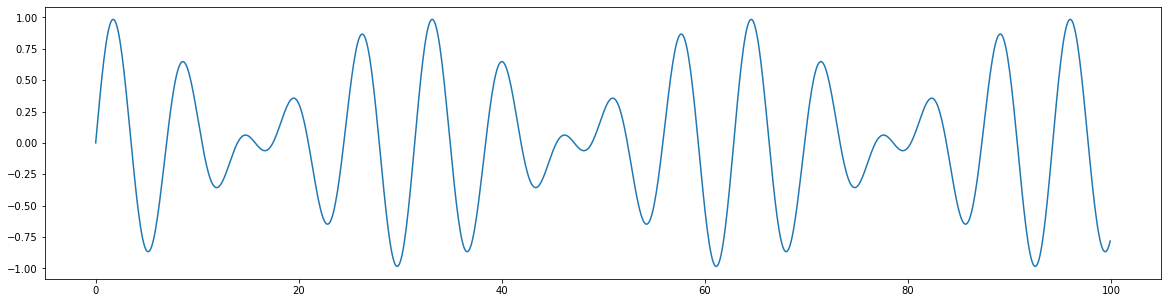

In [24]:
plt.figure(figsize=(20,5))
plt.plot(xs[:1000], ys1[:1000])
plt.show()

In [25]:
aeLoss = []
cxLoss = []
czLoss = []
cx_g_Loss = []
cz_g_Loss = []

E, G, Cx, Cz, ae_model, cx_gan_model, cz_gan_model = init_model()

In [26]:
train_model(ys1, 4, 128)
r1 = get_reconstruction_segment(ae_model, ys1, 0, len(ys1))

train_model(ys1, 16, 128)
r2 = get_reconstruction_segment(ae_model, ys1, 0, len(ys1))

train_model(ys1, 80, 128)
r3 = get_reconstruction_segment(ae_model, ys1, 0, len(ys1))

---------- Epoch: 1, batchCount 78 ----------
---------- Epoch: 2, batchCount 78 ----------
---------- Epoch: 3, batchCount 78 ----------
---------- Epoch: 4, batchCount 78 ----------
Эпоха 4
ae_loss 0.14035679399967194, cx_loss 0.8884952664375305, cz_loss 0.7502533197402954, cx_g_loss 0.3246932625770569, cz_g_loss 0.3345991373062134
---------- Epoch: 1, batchCount 78 ----------
---------- Epoch: 2, batchCount 78 ----------
---------- Epoch: 3, batchCount 78 ----------
---------- Epoch: 4, batchCount 78 ----------
Эпоха 4
ae_loss 0.12437587231397629, cx_loss 0.847093403339386, cz_loss 0.8258517980575562, cx_g_loss 0.3275410234928131, cz_g_loss 0.3627607524394989
---------- Epoch: 5, batchCount 78 ----------
---------- Epoch: 6, batchCount 78 ----------
---------- Epoch: 7, batchCount 78 ----------
---------- Epoch: 8, batchCount 78 ----------
Эпоха 8
ae_loss 0.12008771300315857, cx_loss 0.8498010635375977, cz_loss 0.6813682317733765, cx_g_loss 0.32886773347854614, cz_g_loss 0.249763518

---------- Epoch: 70, batchCount 78 ----------
---------- Epoch: 71, batchCount 78 ----------
---------- Epoch: 72, batchCount 78 ----------
Эпоха 72
ae_loss 0.052685268223285675, cx_loss 0.5880320072174072, cz_loss 0.11006287485361099, cx_g_loss 0.2822417616844177, cz_g_loss 0.021348105743527412
---------- Epoch: 73, batchCount 78 ----------
---------- Epoch: 74, batchCount 78 ----------
---------- Epoch: 75, batchCount 78 ----------
---------- Epoch: 76, batchCount 78 ----------
Эпоха 76
ae_loss 0.050296198576688766, cx_loss 0.3837130665779114, cz_loss 0.10892622172832489, cx_g_loss 0.3664070665836334, cz_g_loss 0.0017590787028893828
---------- Epoch: 77, batchCount 78 ----------
---------- Epoch: 78, batchCount 78 ----------
---------- Epoch: 79, batchCount 78 ----------
---------- Epoch: 80, batchCount 78 ----------
Эпоха 80
ae_loss 0.05852685868740082, cx_loss 0.4745803475379944, cz_loss 0.10997063666582108, cx_g_loss 0.28139010071754456, cz_g_loss 0.0271206833422184


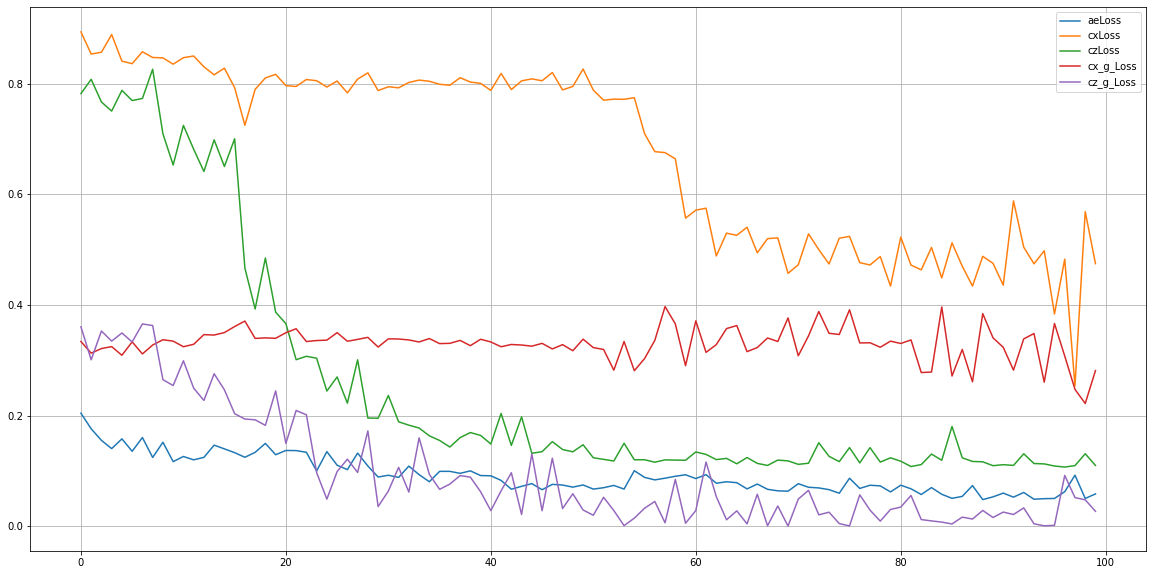

In [27]:
draw_losses(aeLoss, cxLoss, czLoss, cx_g_Loss, cz_g_Loss)

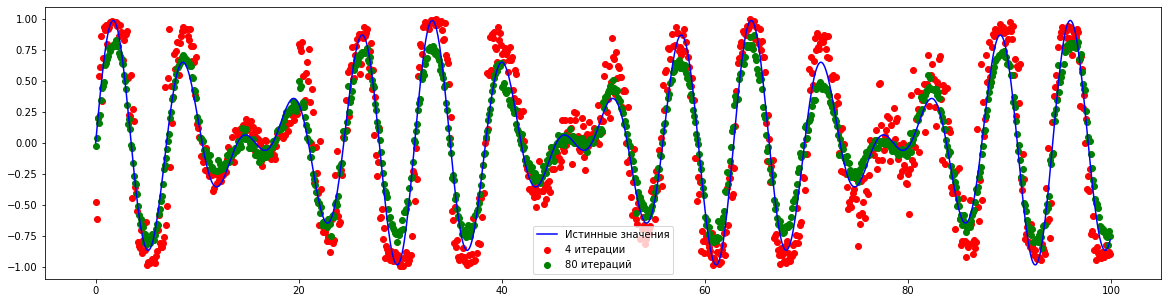

In [28]:
l, r = 0, 1000
plt.figure(figsize=(20,5))
plt.plot(xs[l:r], ys1[l:r], c='b', label='Истинные значения')
plt.scatter(xs[l:r], r1[l:r], c='r', label='4 итерации')
plt.scatter(xs[l:r], r3[l:r], c='g', label='80 итераций')
plt.legend()
plt.show()

<a href='#toc'>Назад к Оглавлению</a>

# Предсказание аномалий в синтетических данных <a name='synth_prediction'></a>

Для небольших тестовых примеров используется временной ряд из 10000 значений на отрезке $x \in [0, 1000]$
$$
\Large
y(x) = \frac{1}{2} \sin(x) + \frac{1}{2} \sin(0.8x),
$$
значения которого меняются в диапазоне от -1 до 1.

### Ряд 1: периодический сигнал, без аномалий <a name='synth-ds1'></a>

In [29]:
xs = np.linspace(0, 1000, 10000)
ys1 = 0.5*np.sin(xs) + 0.5*np.sin(0.8*xs)
label1 = np.zeros(10000)

In [30]:
df = pd.DataFrame({'values': ys1, 'labels': label1})
#df.to_csv('/opt/datasets/cybercerebrum/Article/synth_ds1.csv')

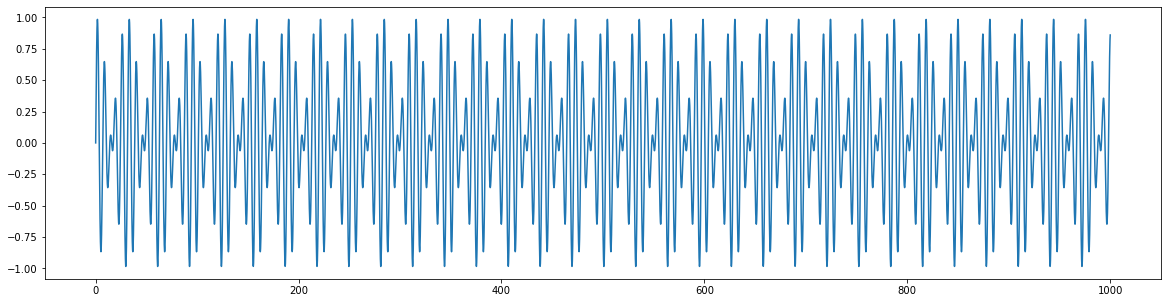

In [31]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys1)
plt.show()

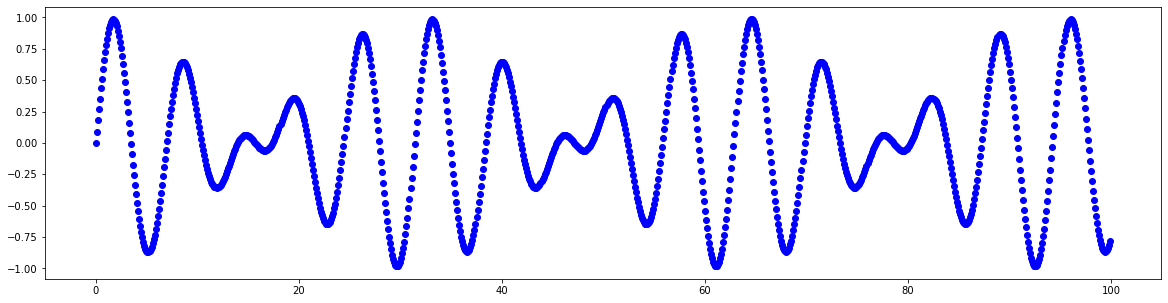

In [32]:
plt.figure(figsize=(20,5))
plt.scatter(xs[:1000], ys1[:1000], c='b')
plt.show()

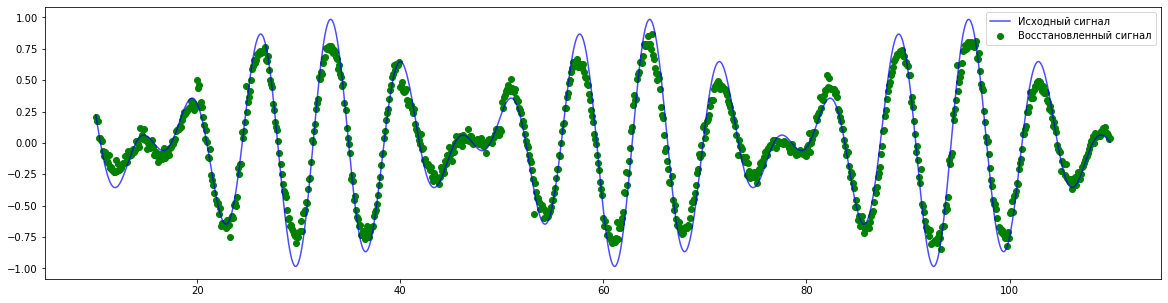

In [33]:
ys1_hat = get_reconstruction_segment(ae_model, ys1, 0, len(ys1))
draw_reconstruction_segment(xs, ys1, ys1_hat, 100, 1100)

In [38]:
labels1 = check_anomaly_pointwise_abs(ys1, ys1_hat, 1)

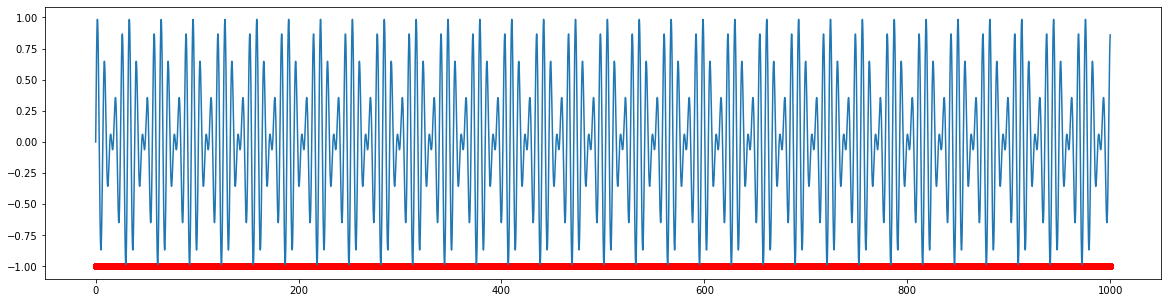

In [35]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys1)
plt.scatter(xs, labels1*(-2)-1, c='red')
plt.show()

<a href='#toc'>Назад к Оглавлению</a>

### Ряд 2: Периодический сигнал, несколько точечных аномалий <a name='synth-ds2'></a>

In [39]:
xs = np.linspace(0, 1000, 10000)
ys2 = 0.5*np.sin(xs) + 0.5*np.sin(0.8*xs)
idxs = np.random.choice(len(ys2), size=5)
max_ = np.max(ys2)
ys2[idxs] = max_*np.random.randint(5)
label2 = np.zeros(10000)
label2[idxs] = 1

In [40]:
df = pd.DataFrame({'values': ys2, 'labels': label2})
#df.to_csv('/opt/datasets/cybercerebrum/Article/synth_ds2.csv')

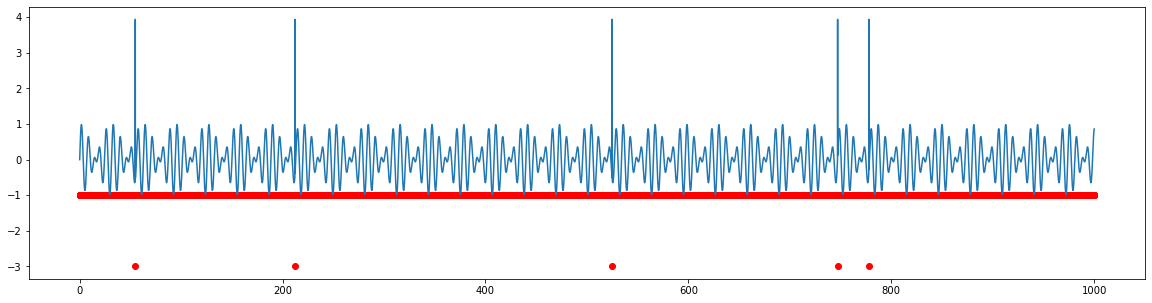

In [41]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys2)
plt.scatter(xs, label2*(-2)-1, c='red')
plt.show()

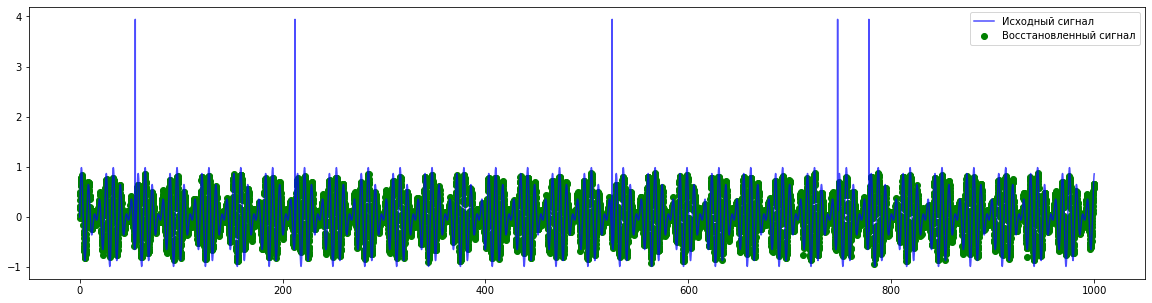

In [42]:
ys2_hat = get_reconstruction_segment(ae_model, ys2, 0, len(ys2))

draw_reconstruction_segment(xs, ys2, ys2_hat, 0, 10000)

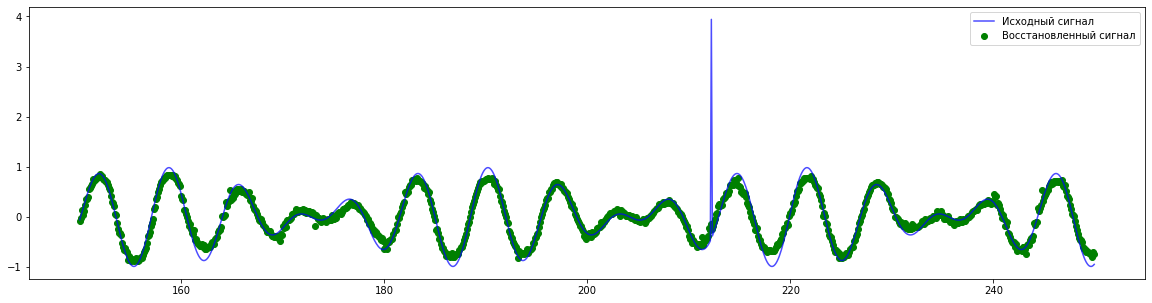

In [43]:
draw_reconstruction_segment(xs, ys2, ys2_hat, 1500, 2500)

In [44]:
labels_ = check_anomaly_pointwise_abs(ys2, ys2_hat, 1)

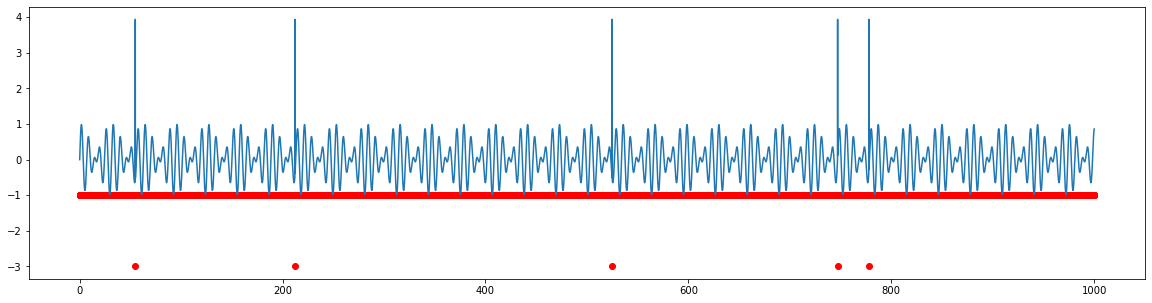

In [45]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys2)
plt.scatter(xs, labels_*(-2)-1, c='red')
plt.show()

In [46]:
f1_score(label2, labels_)

1.0

<a href='#toc'>Назад к Оглавлению</a>

### Ряд 3: Периодический сигнал, плавное изменение амплитуты для некоторых участков <a name='synth-ds3'></a>

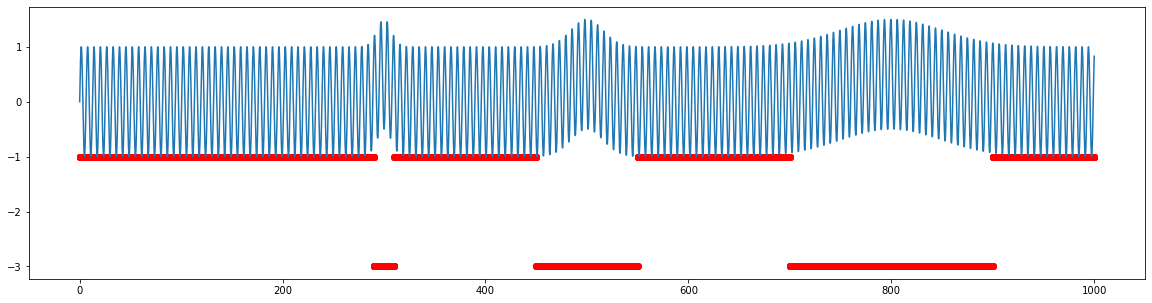

In [47]:
xs = np.linspace(0, 1000, 10000)
ys3 = np.sin(xs)
ys3 += 0.5*np.exp(-(xs-300)**2/100)
ys3 += 0.5*np.exp(-(xs-500)**2/500)
ys3 += 0.5*np.exp(-(xs-800)**2/5000)

label3 = np.zeros(10000)
label3[300*10-100:300*10+100] = 1
label3[500*10-500:500*10+500] = 1
label3[800*10-1000:800*10+1000] = 1

plt.figure(figsize=(20,5))
plt.plot(xs, ys3)
plt.scatter(xs, label3*(-2)-1, c='r')
plt.show()

In [48]:
df = pd.DataFrame({'values': ys3, 'labels': label3})
#df.to_csv('/opt/datasets/cybercerebrum/Article/synth_ds3.csv')

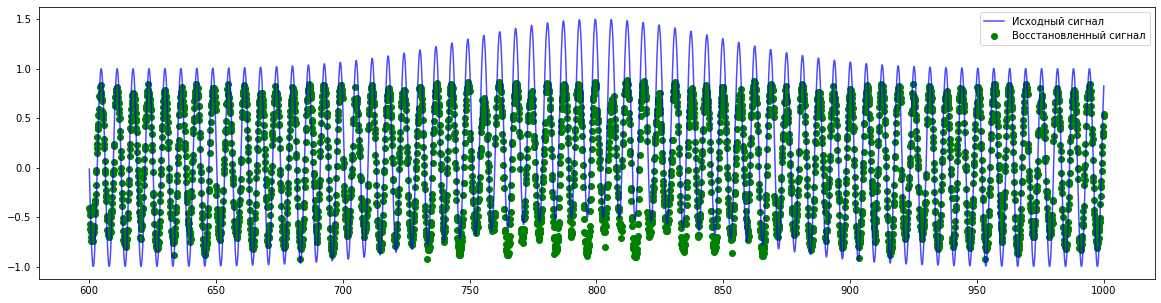

In [49]:
ys3_hat = get_reconstruction_segment(ae_model, ys3, 0, len(ys3))

draw_reconstruction_segment(xs, ys3, ys3_hat, 6000, 10000)

In [68]:
labels_ = check_anomaly_pointwise_abs(ys3, ys3_hat, 0.4)
f1_score(label3, labels_)

0.42124883504193844

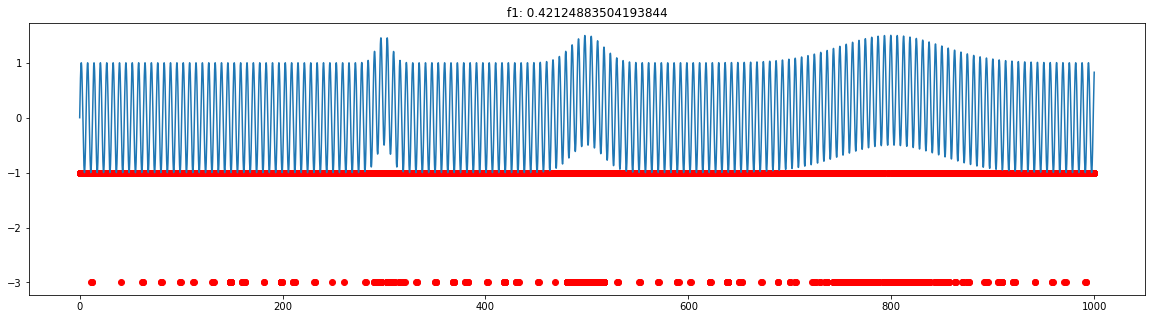

In [69]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys3)
plt.scatter(xs, labels_*(-2)-1, c='red')
plt.title("f1: {}".format(f1_score(label3, labels_)))
plt.show()

<a href='#toc'>Назад к Оглавлению</a>

### Ряд 4: периодический сигнал с аномальным изменением частоты

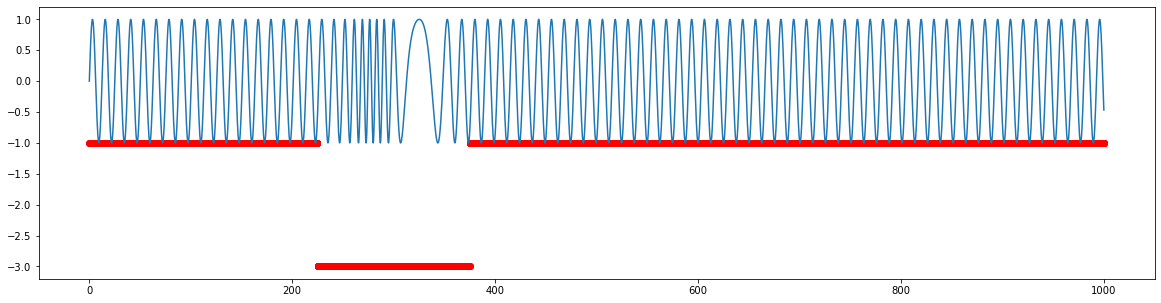

In [70]:
xs = np.linspace(0, 1000, 10000)
ys4 = np.sin(xs*0.5*(1+0.1*np.exp(-(xs-300)**2/1000)))
label4 = np.zeros(10000)
label4[300*10-750:300*10+750] = 1

plt.figure(figsize=(20,5))
plt.scatter(xs, label4*(-2)-1, c='r')
plt.plot(xs, ys4)
plt.show()

In [71]:
df = pd.DataFrame({'values': ys4, 'labels': label4})
#df.to_csv('/opt/datasets/cybercerebrum/Article/synth_ds4.csv')

In [72]:
ys4_hat = get_reconstruction_segment(ae_model, ys4, 0, len(ys4))

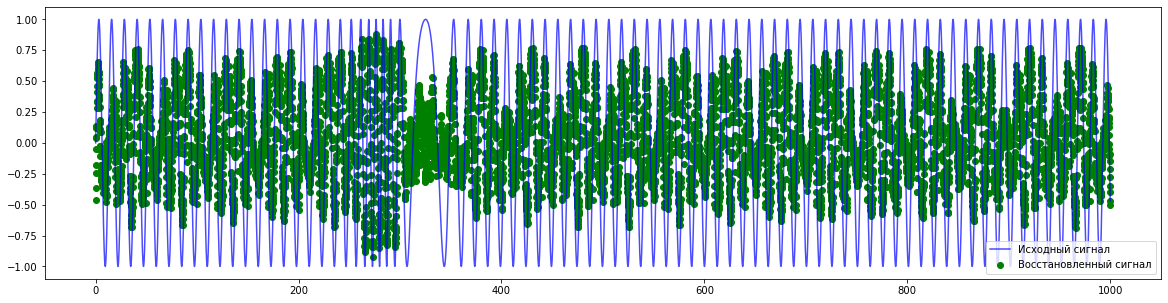

In [73]:
draw_reconstruction_segment(xs, ys4, ys4_hat, 0, len(ys4))

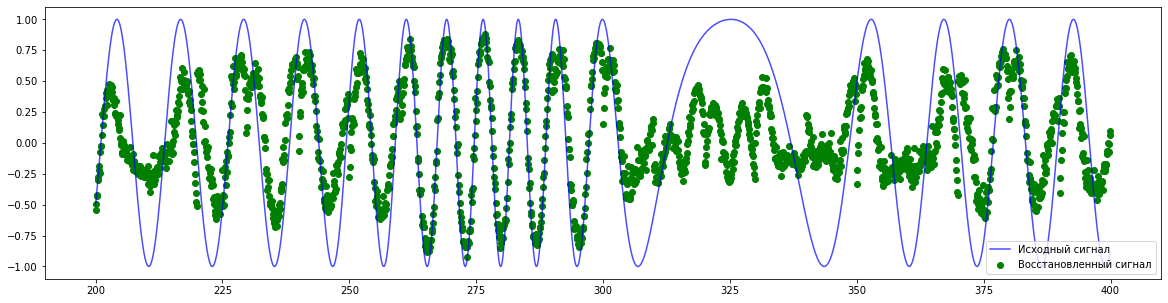

In [74]:
draw_reconstruction_segment(xs, ys4, ys4_hat, 2000, 4000)

In [86]:
labels_ = check_anomaly_pointwise_abs(ys4, ys4_hat, 0.9)
f1_score(label4, labels_)

0.07841031149301826

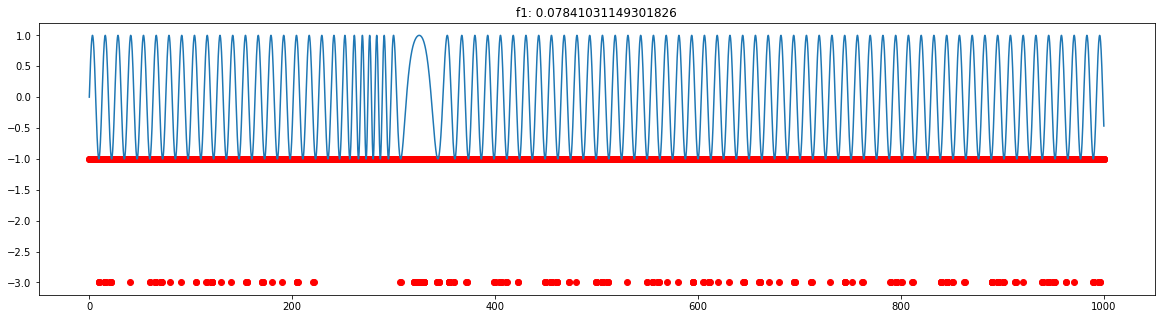

In [87]:
plt.figure(figsize=(20,5))
plt.plot(xs, ys4)
plt.scatter(xs, labels_*(-2)-1, c='red')
plt.title("f1: {}".format(f1_score(label4, labels_)))
plt.show()

#### Ряд 5: Периодический сигнал, эффект "замораживания значения"

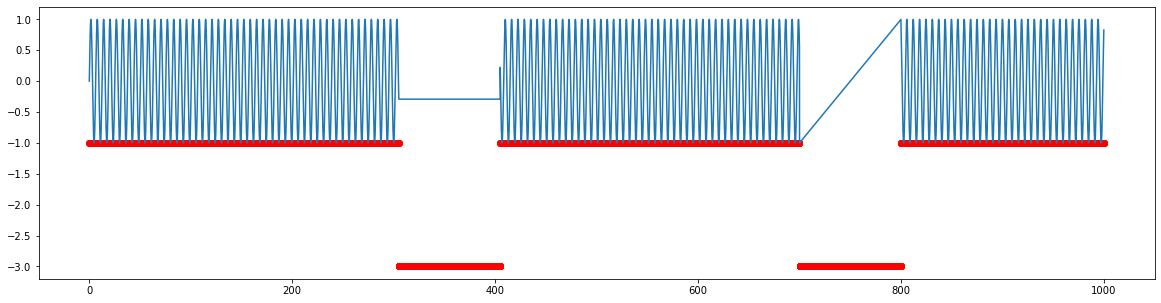

In [88]:
xs = np.linspace(0, 1000, 10000)
ys5 = np.sin(xs)
ys5[3050:4050] =  ys5[3050]

d = (np.max(ys5) - np.min(ys5))/(8000-7000)
m = np.min(ys5)
for i in range(7000, 8000):    
    ys5[i] = m + d*(i-7000)

label5 = np.zeros(10000)
label5[3050:4050] = 1
label5[7000:8000] = 1

plt.figure(figsize=(20,5))
plt.plot(xs, ys5)
plt.scatter(xs, label5*(-2)-1, c='r')
plt.show()

In [89]:
df = pd.DataFrame({'values': ys5, 'labels': label5})
#df.to_csv('/opt/datasets/cybercerebrum/Article/synth_ds5.csv')

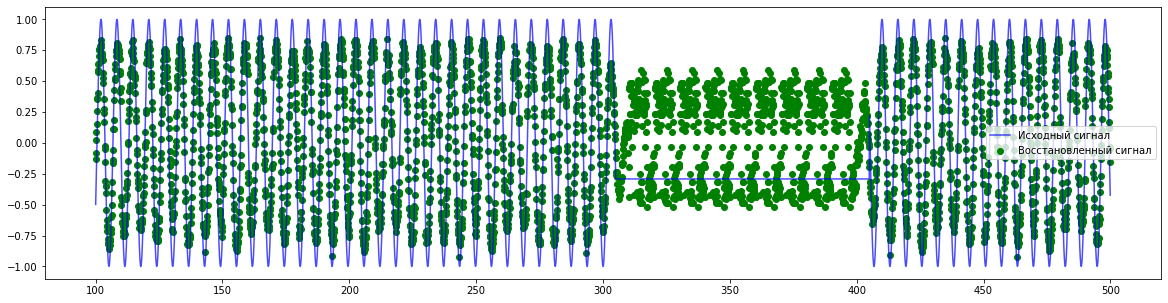

In [90]:
ys5_hat = get_reconstruction_segment(ae_model, ys5, 0, len(ys5))
draw_reconstruction_segment(xs, ys5, ys5_hat, 1000, 5000)

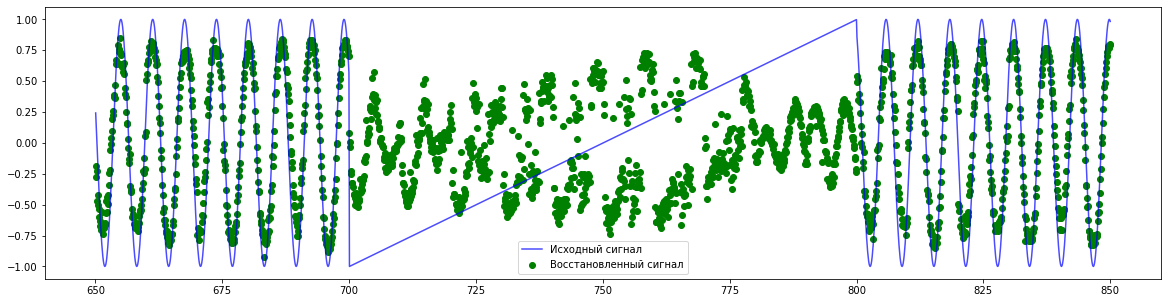

In [91]:
draw_reconstruction_segment(xs, ys5, ys5_hat, 6500, 8500)

<a href='#toc'>Назад к Оглавлению</a>

# Предсказание аномалий в реальных данных <a name='real_prediction'></a>

# Датасет "холодильники" "/opt/datasets/cybercerebrum/Article/labeled&normalized_EDA.csv"

In [107]:
path_ = "/opt/datasets/cybercerebrum/Article/"
file_ = "labeled&normalized_EDA.csv"
df = pd.read_csv(path_+file_, index_col=0)

In [108]:
xs_ds1 = df.index.values
ys_ds1 = df.data.values

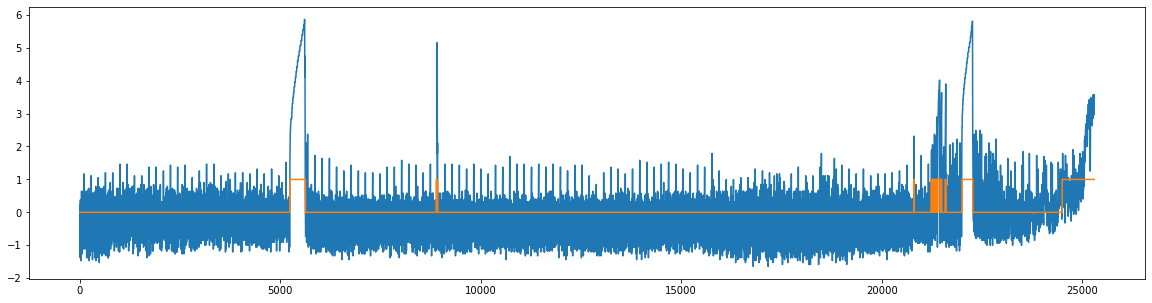

In [109]:
plt.figure(figsize=(20, 5))
plt.plot(df.values)
plt.show()

In [96]:
aeLoss = []
cxLoss = []
czLoss = []
cx_g_Loss = []
cz_g_Loss = []

In [97]:
E, G, Cx, Cz, ae_model, cx_gan_model, cz_gan_model = init_model()

In [98]:
train_model(df.data.values[:5000], 100, 128)

---------- Epoch: 1, batchCount 39 ----------
---------- Epoch: 2, batchCount 39 ----------
---------- Epoch: 3, batchCount 39 ----------
---------- Epoch: 4, batchCount 39 ----------
Эпоха 4
ae_loss 0.3286912441253662, cx_loss 0.7906885147094727, cz_loss 0.8727661371231079, cx_g_loss 0.3331116735935211, cz_g_loss 0.2942301034927368
---------- Epoch: 5, batchCount 39 ----------
---------- Epoch: 6, batchCount 39 ----------
---------- Epoch: 7, batchCount 39 ----------
---------- Epoch: 8, batchCount 39 ----------
Эпоха 8
ae_loss 0.3307512104511261, cx_loss 0.7728828191757202, cz_loss 0.8630936145782471, cx_g_loss 0.360187292098999, cz_g_loss 0.3428354859352112
---------- Epoch: 9, batchCount 39 ----------
---------- Epoch: 10, batchCount 39 ----------
---------- Epoch: 11, batchCount 39 ----------
---------- Epoch: 12, batchCount 39 ----------
Эпоха 12
ae_loss 0.29894232749938965, cx_loss 0.8384156823158264, cz_loss 0.7835149765014648, cx_g_loss 0.3600286841392517, cz_g_loss 0.35471892

---------- Epoch: 98, batchCount 39 ----------
---------- Epoch: 99, batchCount 39 ----------
---------- Epoch: 100, batchCount 39 ----------
Эпоха 100
ae_loss 0.20086362957954407, cx_loss 0.1760220229625702, cz_loss 0.7012576460838318, cx_g_loss 0.07651835680007935, cz_g_loss 0.3994901776313782


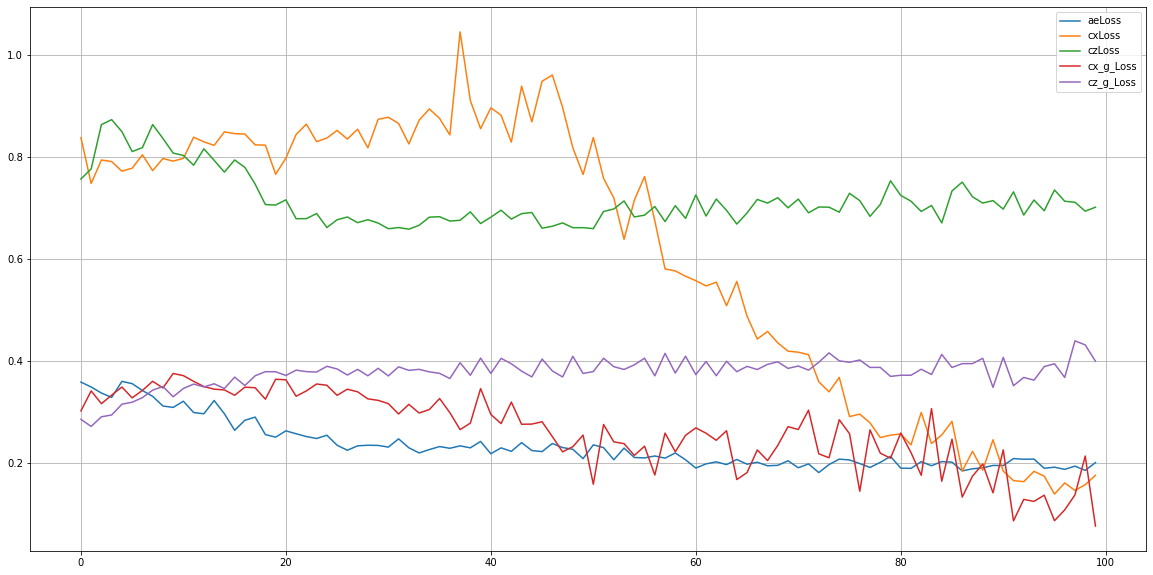

In [99]:
draw_losses(aeLoss, cxLoss, czLoss, cx_g_Loss, cz_g_Loss)

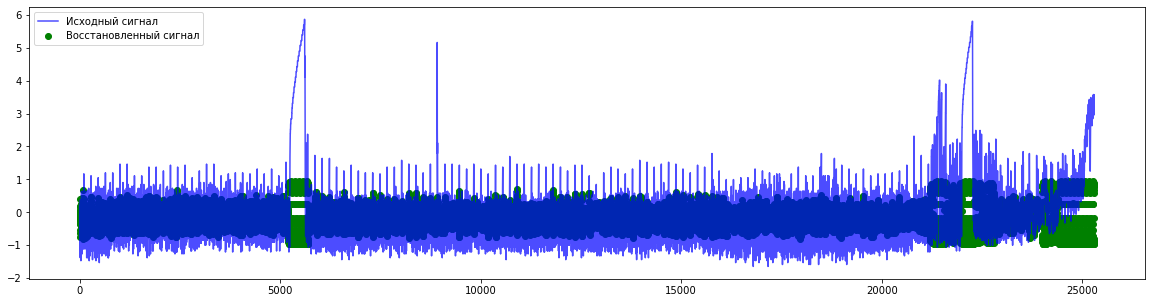

In [110]:
predictions_ = get_reconstruction_segment(ae_model, ys_ds1, 0, len(ys_ds1))
draw_reconstruction_segment(xs_ds1, ys_ds1, predictions_, 0, len(ys_ds1))
labels_ = check_anomaly_pointwise_abs(ys_ds1, predictions_, 1.5)

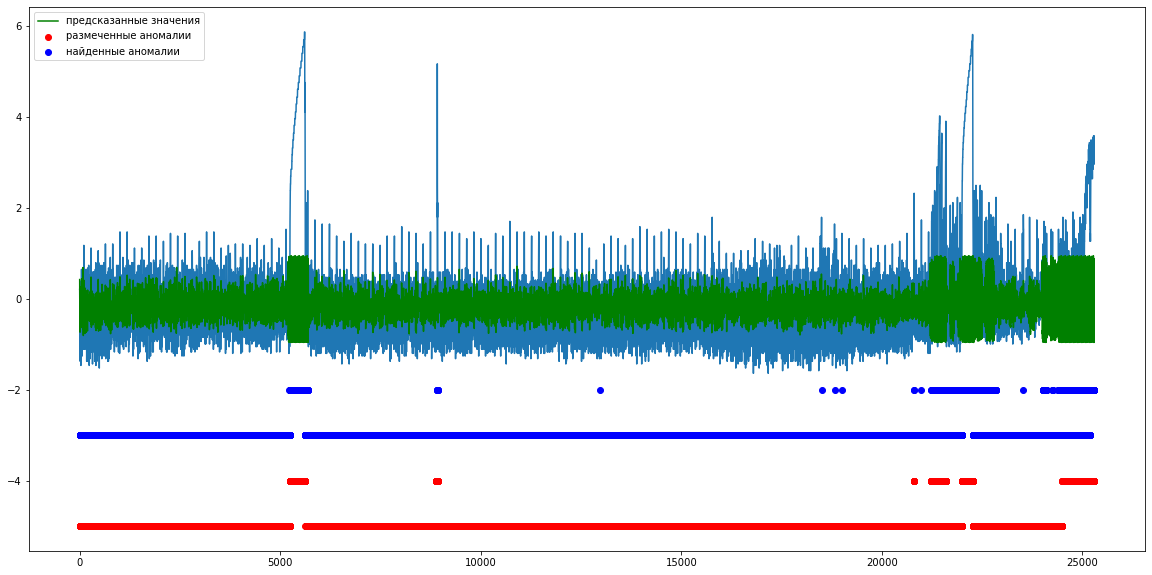

In [112]:
l_, r_ = 0, 25295
plt.figure(figsize=(20,10))
plt.plot(xs_ds1[l_:r_], ys_ds1[l_:r_])
plt.plot(xs_ds1[l_:r_], predictions_[l_:r_], c='g', label="предсказанные значения")
plt.scatter(xs_ds1[l_:r_], df.label.values[l_:r_]-5, c='r', label="размеченные аномалии")
plt.scatter(xs_ds1[l_:r_], np.array(labels_[l_:r_])-3, c='b', label="найденные аномалии")
plt.legend()
plt.show()

In [113]:
f1_score(df.label.values[:len(labels_)], labels_)

0.761274046042258

In [115]:
df_result = pd.read_csv(path_+file_, index_col=0)
df_result['prediction'] = labels_
df_result

,data,label,prediction
0,0.203978,0,0
1,0.203978,0,0
2,-0.413435,0,0
3,-0.265678,0,0
4,-0.413435,0,0
...,...,...,...
25295,2.958590,1,1
25296,2.958590,1,1
25297,3.164394,1,1
25298,3.370198,1,1


In [116]:
df_result.to_csv(path_+"tadgan_labels_"+file_)

In [117]:
path_+"tadgan_labels_"+file_

'/opt/datasets/cybercerebrum/Article/tadgan_labels_labeled&normalized_EDA.csv'

## Датасет 2: энергопотребление в стойке

In [118]:
path_ = "/opt/datasets/cybercerebrum/Article/"
file_ = "KU_load.csv"
df = pd.read_csv(path_+file_, index_col=0, parse_dates=True)

In [119]:
df.columns, len(df)

(Index(['original', 'label'], dtype='object'), 525659)

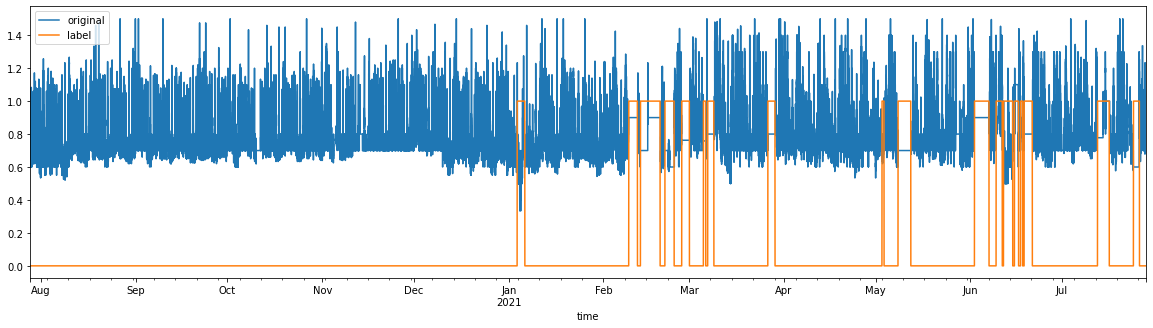

In [120]:
xs_ds2 = df.index.values
ys_ds2 = df.original.values
df.plot(figsize=(20,5))
plt.show()

In [121]:
df.isna().sum()

original    0
label       0
dtype: int64

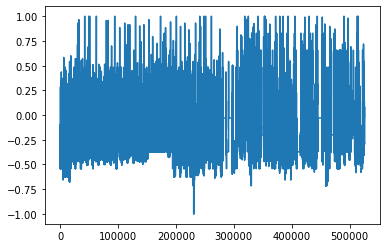

In [122]:
ys_ds2 = MinMaxScaler([-1,1]).fit_transform(ys_ds2.reshape(-1,1)).squeeze()

plt.plot(ys_ds2)
plt.show()

In [123]:
aeLoss = []
cxLoss = []
czLoss = []
cx_g_Loss = []
cz_g_Loss = []

In [124]:
E, G, Cx, Cz, ae_model, cx_gan_model, cz_gan_model = init_model()

In [125]:
train_model(ys_ds2[:10_000], 50, 128)

---------- Epoch: 1, batchCount 78 ----------
---------- Epoch: 2, batchCount 78 ----------
---------- Epoch: 3, batchCount 78 ----------
---------- Epoch: 4, batchCount 78 ----------
Эпоха 4
ae_loss 0.13555121421813965, cx_loss 0.8886204957962036, cz_loss 0.5380169749259949, cx_g_loss 0.31190645694732666, cz_g_loss 0.1341126710176468
---------- Epoch: 5, batchCount 78 ----------
---------- Epoch: 6, batchCount 78 ----------
---------- Epoch: 7, batchCount 78 ----------
---------- Epoch: 8, batchCount 78 ----------
Эпоха 8
ae_loss 0.0647505670785904, cx_loss 0.8528111577033997, cz_loss 0.33870217204093933, cx_g_loss 0.33148518204689026, cz_g_loss 0.08543295413255692
---------- Epoch: 9, batchCount 78 ----------
---------- Epoch: 10, batchCount 78 ----------
---------- Epoch: 11, batchCount 78 ----------
---------- Epoch: 12, batchCount 78 ----------
Эпоха 12
ae_loss 0.06002713367342949, cx_loss 0.8384690880775452, cz_loss 0.3277300000190735, cx_g_loss 0.3305514454841614, cz_g_loss 0.08

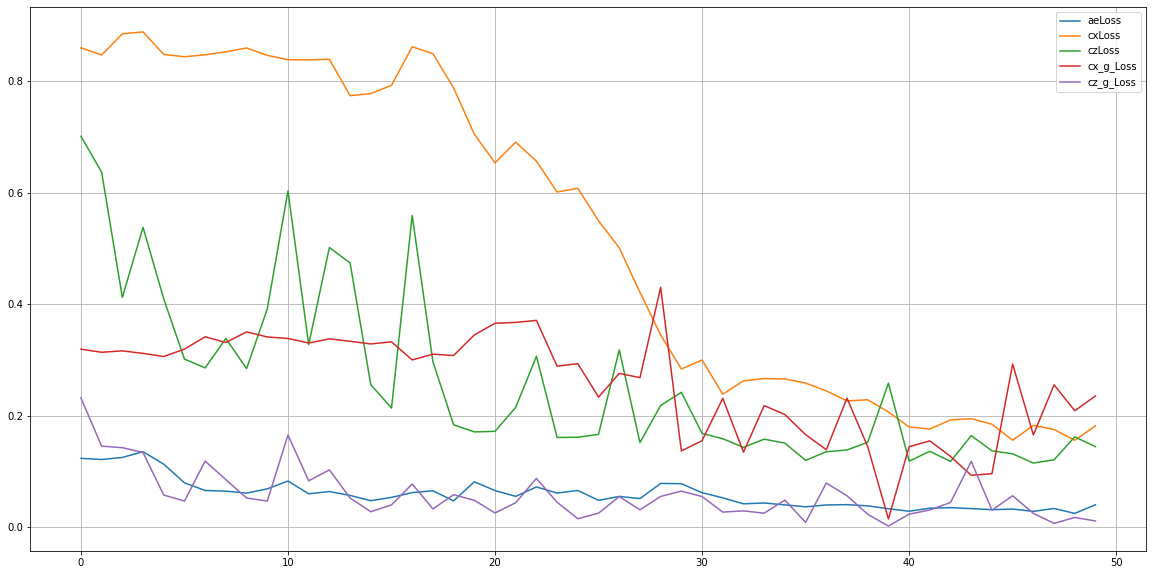

In [126]:
draw_losses(aeLoss, cxLoss, czLoss, cx_g_Loss, cz_g_Loss)

In [127]:
predictions_ = get_reconstruction_segment(ae_model, ys_ds2, 0, len(ys_ds2))

In [128]:
labels_ = check_anomaly_pointwise_abs(ys_ds2, predictions_, 0.001)
f1_score(df.label.values[:len(labels_)], labels_)

0.22822334340144776

In [ ]:
draw_reconstruction_segment(xs_ds2, ys_ds2, predictions_, 0, len(ys_ds2))

In [ ]:
l_, r_ = 0, len(ys_ds2)

plt.figure(figsize=(20,10))
plt.plot(xs_ds2[l_:r_], ys_ds2[l_:r_], label='значения ряда')
plt.plot(xs_ds2[l_:r_], predictions_[l_:r_], c='g', label="предсказанные значения")
plt.scatter(xs_ds2[l_:r_], df.label.values[l_:r_]-5, c='r', label="размеченные аномалии")
plt.scatter(xs_ds2[l_:r_], np.array(labels_[l_:r_])-3, c='b', label="найденные аномалии")
plt.legend()
plt.show()

In [ ]:
f1_score(df.label.values[:len(labels_)], labels_)

In [ ]:
df_result = pd.read_csv(path_, index_col=0)
df_result['prediction'] = labels_
df_result

In [ ]:
df_result.to_csv(path_+"tadgan_labels_"+file_)

## Датасет 3: NAB

In [ ]:
path_ = "/opt/datasets/cybercerebrum/Article/NAB_train&test/labeled_NAB_test.csv"
df = pd.read_csv(path_, index_col=0, parse_dates=True)
print(df.columns)
df.plot(figsize=(20,5))
plt.show()

In [ ]:
xs_ds3 = df.index.values
ys_ds3 = df.value.values

In [ ]:
ys_ds3 = MinMaxScaler([-1,1]).fit_transform(ys_ds3.reshape(-1,1)).squeeze()
plt.plot(ys_ds3)
plt.show()

In [ ]:
df.isna().sum()

In [ ]:
aeLoss = []
cxLoss = []
czLoss = []
cx_g_Loss = []
cz_g_Loss = []

In [ ]:
E, G, Cx, Cz, ae_model, cx_gan_model, cz_gan_model = init_model()

In [ ]:
ys_ds3.shape

In [ ]:
plt.plot(ys_ds3[:2500])
plt.plot()

In [ ]:
train_model(ys_ds3[:2500], 40, 40)

In [ ]:
draw_losses(aeLoss, cxLoss, czLoss, cx_g_Loss, cz_g_Loss)

In [ ]:
predictions_ = get_reconstruction_segment(ae_model, ys_ds3, 0, len(ys_ds3))

In [ ]:
draw_reconstruction_segment(xs_ds3, ys_ds3, predictions_, 0, len(ys_ds3))

In [ ]:
labels_ = check_anomaly_pointwise_abs(ys_ds3, predictions_, 1.2)
f1_score(df.label.values[:len(labels_)], labels_)

In [ ]:
l_, r_ = 0, 25295
plt.figure(figsize=(20,10))
plt.plot(xs_ds3[l_:r_], ys_ds3[l_:r_])
plt.plot(xs_ds3[l_:r_], predictions_[l_:r_], c='g', label="предсказанные значения")
plt.scatter(xs_ds3[l_:r_], df.label.values[l_:r_]-5, c='r', label="размеченные аномалии")
plt.scatter(xs_ds3[l_:r_], np.array(labels_[l_:r_])-3, c='b', label="найденные аномалии")
plt.title("f1: {}".format(f1_score(df.label.values[:len(labels_)], labels_)))
plt.legend()
plt.show()

In [ ]:
df_result = pd.read_csv(path_, index_col=0)
df_result['prediction'] = labels_
df_result

In [ ]:
df_result.to_csv(path_+"tadgan_labels_"+file_)

## Датасет 4: NASA

In [ ]:
path_ = "/opt/datasets/cybercerebrum/Article/NASA_train&test/labeled_nasa_test.csv"
df = pd.read_csv(path_, index_col=0, parse_dates=True)
print(df.columns)
df.plot(figsize=(20,5))
plt.show()

In [ ]:
xs_ds4 = df.index.values
ys_ds4 = df['0'].values

In [ ]:
df.isna().sum()

In [ ]:
aeLoss = []
cxLoss = []
czLoss = []
cx_g_Loss = []
cz_g_Loss = []

In [ ]:
#ys_ds4 = MinMaxScaler([-1,1]).fit_transform(ys_ds4.reshape(-1,1)).squeeze()

plt.figure(figsize=(20,5))
plt.plot(ys_ds4)
plt.show()

In [ ]:
E, G, Cx, Cz, ae_model, cx_gan_model, cz_gan_model = init_model()

In [ ]:
train_model(ys_ds4[:2000], 40, 64)

In [ ]:
draw_losses(aeLoss, cxLoss, czLoss, cx_g_Loss, cz_g_Loss)

In [ ]:
predictions_ = get_reconstruction_segment(ae_model, ys_ds4, 0, len(ys_ds4))

In [ ]:
draw_reconstruction_segment(xs_ds4, ys_ds4, predictions_, 0, len(ys_ds4))

In [ ]:
draw_reconstruction_segment(xs_ds4, ys_ds4, predictions_, 2000, 3000)

In [ ]:
labels_ = check_anomaly_pointwise_abs(ys_ds4, predictions_, 0.8)
f1_score(df['nasa_label'].values[:len(labels_)], labels_)

In [ ]:
df.columns

In [ ]:
l_, r_ = 0, 25295
plt.figure(figsize=(20,10))
plt.plot(xs_ds4[l_:r_], ys_ds4[l_:r_])
plt.plot(xs_ds4[l_:r_], predictions_[l_:r_], c='g', label="предсказанные значения")
plt.scatter(xs_ds4[l_:r_], df['nasa_label'].values[l_:r_]-5, c='r', label="размеченные аномалии")
plt.scatter(xs_ds4[l_:r_], np.array(labels_[l_:r_])-3, c='b', label="найденные аномалии")
#plt.title("f1: {}".format(f1_score(df['0'].values[:len(labels_)], labels_)))
plt.legend()
plt.show()

In [ ]:
df_result = pd.read_csv(path_, index_col=0)
df_result['prediction'] = labels_
df_result

In [ ]:
df_result.to_csv(path_+"tadgan_labels_"+file_)

<a href='#toc'>Назад к Оглавлению</a>

# Ссылки <a name='links'></a>

- "TadGAN: Time Series Anomaly Detection Using Generative Adversarial Networks" https://arxiv.org/abs/2009.07769 

- "TadGAN: Обнаружение аномалий временных рядов с использованием генеративных состязательных сетей" https://www.youtube.com/watch?v=jIDj2dhU99k

- https://github.com/signals-dev/Orion

- Доклад Чернышова Ю.Ю. на семинаре "UralSeminars" 03.06.2021 https://www.youtube.com/watch?v=W5-AiV7ZRpg

<a href='#toc'>Назад к Оглавлению</a>